In [1]:
import gc
import logging
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
import re
import sys
import subprocess
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass, field
from typing import (
    Any,
    Dict,
    List,
    Optional,
    Sequence,
    TextIO,
    Tuple,
    Union,
)

from aenum import Enum
from filelock import FileLock
from IPython.display import clear_output
from nltk.corpus import stopwords
from seqeval.metrics import (
    f1_score,
    recall_score,
    precision_score
)
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelForTokenClassification,
    AutoModel, 
    AutoTokenizer,
    EvalPrediction,
    HfArgumentParser,
    PreTrainedTokenizer,
    Trainer, 
    TrainingArguments,
    default_data_collator,
    get_scheduler,
    set_seed
)

# NER finetuning and savind to "best_model.ckpt"

In [2]:
class Split(Enum):
    train = "train_dev"
    dev = "devel"
    test = "test"

In [3]:
model_name = "dmis-lab/biobert-base-cased-v1.1"
data_dir = "../datasets/NCBI/NCBI-disease"
labels_dir = "../datasets/NCBI/NCBI-disease/labels.txt"
output_dir = "./output/NCBI/NER"

In [4]:
getattr(Split, "train").value

'train_dev'

In [5]:
def get_dataset(data_dir: str, label2id: Dict[str, int]) -> Dict[str, Dataset]:
    dataset = {}
    for mode in ["train", "dev", "test"]:
        mode = getattr(Split, mode).value
        
        file_path = os.path.join(data_dir, f"{mode}.txt")
        guid_index = 1
        samples = []
        with open(file_path, encoding="utf-8") as file:
            words = []
            labels = []
            for line in file:
                if line == "" or line == "\n":
                    if words:
                        samples.append({
                            "ner_tags": [label2id[label] for label in labels],
                            "words": words,
                            "ner": labels,
                            "id": guid_index,
                            "title": None,
                        })
                        guid_index += 1
                        words = []
                        labels = []
                else:
                    tokens = line.split(" ")
                    words.append(tokens[0])
                    if len(tokens) > 1:
                        label = tokens[-1].replace("\n", "")
                        if label == "O":
                            labels.append(label)
                        else:
                            labels.append(label + "-bio")
                    else:
                        labels.append("O")
            if words:
                samples.append({
                            "ner_tags": [label2id[label] for label in labels],
                            "words": words,
                            "ner": labels,
                            "id": guid_index,
                            "title": None,
                        })
            dataset[mode] = samples
    return dataset
        

In [6]:
def get_labels_and_label2id(labels_dir: str) -> List[str]:
    labels = [item.strip() + "-bio" if item.strip() != "O" else item.strip()
              for item in open(labels_dir, "r").readlines()]
    label2id = {label: idx for idx, label in enumerate(labels)}
    return labels, label2id

In [7]:
labels, label2id = get_labels_and_label2id(labels_dir)

In [8]:
dataset = get_dataset(data_dir=data_dir, label2id=label2id)

In [9]:
def ner_render(words: List[str], ner: List[str], title: Optional[str] = None, **kwargs):
    pos = 0
    ents = []
    for word, tag in zip(words, ner):
        if tag.startswith('B'):
            ents.append({
                "start": pos,
                "end": pos + len(word),
                "label": tag.split("-")[1]
            })
        elif tag.startswith('I'):
            ents[-1]["end"] = pos + len(word)
        pos += (len(word) + 1)
    displacy.render({
        "text": " ".join(words),
        "ents": ents,
        "title": title
    }, style="ent", manual=True)
    

In [10]:
from spacy import displacy

In [11]:
ner_render(**dataset['test'][600])

In [12]:
tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        cache_dir=output_dir
    )

In [13]:
config = AutoConfig.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label={v: k for k, v in label2id.items()},
        label2id=label2id,
        cache_dir=output_dir
    )

In [14]:
model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        from_tf=bool(".ckpt" in model_name),
        config=config,
        cache_dir=output_dir
    )

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

In [15]:
encoded = tokenizer(dataset['test'][600]["words"], is_split_into_words=True)

In [16]:
encoded

{'input_ids': [101, 1167, 5909, 117, 1780, 1103, 3418, 1104, 1103, 2025, 1110, 2609, 117, 1175, 1110, 170, 5417, 1115, 11109, 1169, 11552, 1126, 22233, 2386, 4179, 8241, 1988, 1134, 1110, 5576, 16618, 5822, 1895, 1118, 3254, 18505, 1106, 3702, 12139, 113, 172, 1204, 114, 1137, 182, 2047, 3622, 117, 1105, 1115, 1103, 2299, 1634, 1104, 27629, 1358, 11363, 1103, 1965, 1104, 24928, 22497, 1348, 1260, 27054, 6108, 1107, 2393, 1181, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
print(f"Original sentence:\n---\n{' '.join(dataset['test'][600]['words'])}")

tokenized = " ".join([tokenizer.convert_ids_to_tokens(id_) for id_ in encoded["input_ids"]])
print(f"\nTokenized sentence:\n---\n{tokenized}")

Original sentence:
---
Moreover , although the scale of the study is limited , there is a possibility that PET can detect an insidious lesion which is undetectable by computed tomogram ( CT ) or MRI analysis , and that the higher level of tau reflects the process of neuronal degeneration in ALD .

Tokenized sentence:
---
[CLS] more ##over , although the scale of the study is limited , there is a possibility that pet can detect an ins ##id ##ious les ##ion which is und ##ete ##ct ##able by com ##puted to ##mo ##gram ( c ##t ) or m ##ri analysis , and that the higher level of ta ##u reflects the process of ne ##uron ##al de ##gene ##ration in al ##d . [SEP]


In [18]:
class ModeDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

In [19]:
def tokenize_and_preserve_tags(example: Dict[str, Any],
                               tokenizer: AutoTokenizer,
                               label2id: Dict[str, int],
                               tokenizer_params={}) -> Dict[str, Any]:

    encoded = tokenizer(example["words"], is_split_into_words=True, **tokenizer_params)
    encoded.update(example)
    
    word_ids = encoded.word_ids()
    text_labels = []
    for i in range(1, len(word_ids) - 1):
        label = example["ner"][word_ids[i]]
        if label == "O" or word_ids[i - 1] != word_ids[i]:
            text_labels.append(label)
        else:
            text_labels.append("I" + label[1:])
    text_labels = ["O"] + text_labels + ["O"]
    
    encoded['labels'] = [label2id[label] for label in text_labels]
    encoded['text_labels'] = text_labels
    
    for key in ['labels', 'input_ids', 'attention_mask', 'token_type_ids']:
        encoded[key] = torch.tensor(encoded[key])
    
    assert len(encoded['labels']) == len(encoded["input_ids"])
    return encoded

In [20]:
def tokenize_and_preserve_tags_in_dataset(
    dataset: Dict[str, List[Dict[str, Any]]],
    tokenizer: AutoTokenizer,
    label2id: Dict[str, int]
) -> Dict[str, List[Dict[str, Any]]]:
    new_dataset = {}
    for key in dataset:
        data = dataset[key]
        
        for example in data:
            new_dataset.setdefault(key, []).append(tokenize_and_preserve_tags(example, tokenizer, label2id))
    for key in dataset:
        new_dataset[key] = ModeDataset(new_dataset[key])
    return new_dataset

In [21]:
tokenized_dataset = tokenize_and_preserve_tags_in_dataset(dataset, tokenizer, label2id)

In [22]:
class PadSequence:
    def __init__(self, padded_columns):
        self.padded_columns = set(padded_columns)

    def __call__(self, batch):
        padded_batch = {}
        for example in batch:
            for key, tensor in example.items():
                padded_batch.setdefault(key, []).append(tensor)
                
        for key, val in padded_batch.items():
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True)
        return padded_batch

In [23]:
test_dataloader = torch.utils.data.DataLoader(tokenized_dataset["test"], batch_size=4, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

In [24]:
test_batch = next(iter(test_dataloader))
model_output = model(input_ids=test_batch["input_ids"],
                     token_type_ids=test_batch["token_type_ids"],
                     attention_mask=test_batch["attention_mask"],
                     labels=test_batch["labels"], return_dict=True)

In [2]:
device = torch.device('cuda:2')

In [26]:
class NamedEntityPredictor:
    def __init__(self,
                 model: AutoModelForTokenClassification,
                 tokenizer: AutoTokenizer,
                 id2label: Optional[Dict[str, int]] = None):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.id2label = model.config.id2label if id2label is None else id2label
    
    def predict(self, batch: Dict[str, Any]):
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(input_ids=batch["input_ids"].to(device),
                                      token_type_ids=batch["token_type_ids"].to(device),
                                      attention_mask=batch["attention_mask"].to(device),
                                      labels=batch["labels"].to(device),
                                      return_dict=True)
        indices = torch.argmax(model_output.logits, axis=2)
        indices = indices.detach().cpu().numpy()
        attention_mask = batch["attention_mask"].cpu().numpy()
        batch_size = len(batch["input_ids"])
        predicted_labels = []
        for i in range(batch_size):
            predicted_labels.append([self.id2label[id_] for id_ in indices[i][attention_mask[i] == 1]])
            
        return {
            "predicted_labels": predicted_labels,
            "loss": model_output.loss,
            "logits": model_output.logits
        }

In [27]:
ner = NamedEntityPredictor(model, tokenizer)
test_prediction = ner.predict(test_batch)
assert len(test_prediction['predicted_labels'][2]) == len(list(test_batch["text_labels"][2]))

In [512]:
ner = NamedEntityPredictor(model, tokenizer)
predicted_labels = []

for batch in tqdm(test_dataloader):
    predicted_labels.extend(ner.predict(batch)["predicted_labels"])

100%|██████████| 30/30 [00:03<00:00,  8.97it/s]


In [511]:
model.load_state_dict(torch.load("finetuned_85_89.ckpt"))

<All keys matched successfully>

In [82]:
from seqeval.metrics import classification_report

In [513]:
print(classification_report(y_true=[list(example["text_labels"]) for example in tokenized_dataset["test"]],
                                                     y_pred=predicted_labels))

              precision    recall  f1-score   support

         bio       0.85      0.89      0.87       960

   micro avg       0.85      0.89      0.87       960
   macro avg       0.85      0.89      0.87       960
weighted avg       0.85      0.89      0.87       960



In [32]:
def clear_cuda_cache():
    gc.collect()

    torch.cuda.empty_cache()

In [33]:
def get_dummy_model_optimizer(device, lr):
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        from_tf=bool(".ckpt" in model_name),
        config=config,
        cache_dir=output_dir
    ).to(device)
    optimizer = AdamW(model.parameters(), lr=lr)
    return model, optimizer

In [34]:
def train(model, optimizer, loader, scheduler):
    model.train()
    losses_tr = []
    for batch in tqdm(loader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
#         scheduler.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for batch in tqdm(loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [35]:
def learning_loop(
    model: AutoModelForTokenClassification,
    epochs: int,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    scheduler: torch.optim.lr_scheduler.LambdaLR,
    optimizer: AdamW,
):
    losses = {'train': [], 'val': []}
    for epoch in range(1, epochs + 1):
        print(f'#{epoch}/{epochs}:')
        clear_cuda_cache()
        
        model, optimizer, loss = train(model, optimizer, train_loader, scheduler)
        losses['train'].append(loss)
        
        if test_loader is not None:
            loss = val(model, test_loader)
            losses['val'].append(loss)

        if scheduler:
            scheduler.step(loss)
        
        clear_output(True)
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        fig.suptitle(f'#{epoch}/{epochs}:')
        
        plt.title('loss on train')
        plt.plot(losses['train'], 'r.-', label='train')
        plt.legend()
        
        plt.title('loss on validation')
        plt.plot(losses['val'], 'g.-', label='val')
        plt.legend()

        plt.show()

    return model, optimizer, losses

In [36]:
list(tokenized_dataset.keys())

['train_dev', 'devel', 'test']

In [38]:
train_dataloader = torch.utils.data.DataLoader(tokenized_dataset["train_dev"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))
test_dataloader = torch.utils.data.DataLoader(tokenized_dataset["test"], batch_size=32, collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels']))

In [76]:
del model, optimizer

NameError: name 'model' is not defined

In [77]:
model, optimizer = get_dummy_model_optimizer(device, 1e-5)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

In [78]:
epochs = 50

In [79]:
scheduler = get_scheduler('cosine', optimizer=optimizer, num_warmup_steps=0, num_training_steps=epochs * len(train_dataloader))

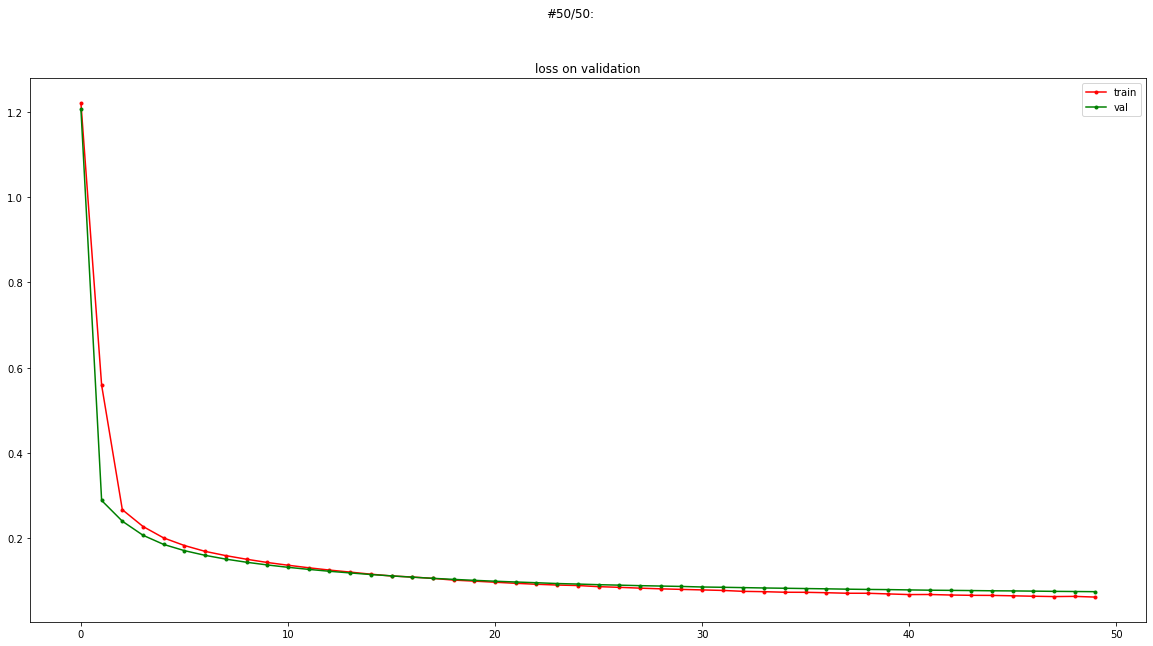

In [80]:
model, optimizer, losses = learning_loop(
    model=model,
    epochs=epochs,
    optimizer=optimizer,
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    scheduler=scheduler
)

In [63]:
torch.save(model.state_dict(), "finetuned_85_89.ckpt")

# Re-Ranking system

## Opening MEDIC dataset

In [88]:
!ls ../datasets/MEDIC/CTD_diseases.csv

CTD_diseases.csv


In [90]:
medic_path = '../datasets/MEDIC/CTD_diseases.csv'

In [97]:
columns = [col for col in
           "DiseaseName,DiseaseID,AltDiseaseIDs,Definition,ParentIDs,TreeNumbers,ParentTreeNumbers,Synonyms,SlimMappings".split(',')]

In [98]:
columns

['DiseaseName',
 'DiseaseID',
 'AltDiseaseIDs',
 'Definition',
 'ParentIDs',
 'TreeNumbers',
 'ParentTreeNumbers',
 'Synonyms',
 'SlimMappings']

In [100]:
MEDIC = pd.read_csv(medic_path, sep=',', comment='#', names=columns)

In [101]:
MEDIC.head()

,DiseaseName,DiseaseID,AltDiseaseIDs,Definition,ParentIDs,TreeNumbers,ParentTreeNumbers,Synonyms,SlimMappings
0,10p Deletion Syndrome (Partial),MESH:C538288,NaN,NaN,MESH:D002872|MESH:D025063,C16.131.260/C538288|C16.320.180/C538288|C23.55...,C16.131.260|C16.320.180|C23.550.210.050.500.500,"Chromosome 10, 10p- Partial|Chromosome 10, mon...",Congenital abnormality|Genetic disease (inborn...
1,13q deletion syndrome,MESH:C535484,NaN,NaN,MESH:D002872|MESH:D025063,C16.131.260/C535484|C16.320.180/C535484|C23.55...,C16.131.260|C16.320.180|C23.550.210.050.500.500,Chromosome 13q deletion|Chromosome 13q deletio...,Congenital abnormality|Genetic disease (inborn...
2,15q24 Microdeletion,MESH:C579849,DO:DOID:0060395,NaN,MESH:D002872|MESH:D008607|MESH:D025063,C10.597.606.360/C579849|C16.131.260/C579849|C1...,C10.597.606.360|C16.131.260|C16.320.180|C23.55...,15q24 Deletion|15q24 Microdeletion Syndrome|In...,Congenital abnormality|Genetic disease (inborn...
3,16p11.2 Deletion Syndrome,MESH:C579850,NaN,NaN,MESH:D001321|MESH:D002872|MESH:D008607|MESH:D0...,C10.597.606.360/C579850|C16.131.260/C579850|C1...,C10.597.606.360|C16.131.260|C16.320.180|C23.55...,NaN,Congenital abnormality|Genetic disease (inborn...
4,"17,20-Lyase Deficiency, Isolated",MESH:C567076,NaN,NaN,MESH:D000312,C12.706.316.090.500/C567076|C13.351.875.253.09...,C12.706.316.090.500|C13.351.875.253.090.500|C1...,"17-Alpha-Hydroxylase-17,20-Lyase Deficiency, C...",Congenital abnormality|Endocrine system diseas...


### Getting concept list

In [104]:
@dataclass
class Concept:
    disease_name: str
    disease_id: str
    parent_ids: List[str]
    synonyms: List[str]

In [108]:
def get_concepts_list(MEDIC: pd.DataFrame) -> List[Concept]:
    if not isinstance(MEDIC, pd.DataFrame):
        raise ValueError("MEDIC is not a DataFrame")
    
    MEDIC1 = MEDIC.fillna("")
    concepts: List[Concept] = []
    for i in range(len(MEDIC1)):
        record = MEDIC1.iloc[i]
        concepts.append(Concept(
            disease_name=record['DiseaseName'],
            disease_id=record['DiseaseID'],
            parent_ids=record['ParentIDs'].split('|'),
            synonyms=record['Synonyms'].split('|')
        ))
    
    return concepts

In [109]:
concepts = get_concepts_list(MEDIC)

In [110]:
concepts[0]

Concept(disease_name='10p Deletion Syndrome (Partial)', disease_id='MESH:C538288', parent_ids=['MESH:D002872', 'MESH:D025063'], synonyms=['Chromosome 10, 10p- Partial', 'Chromosome 10, monosomy 10p', 'Chromosome 10, Partial Deletion (short arm)', 'Monosomy 10p'])

## Preprocessing step

### Getting mentions list

In [264]:
TEXT_LINE_RE = re.compile(r'^(\d+)\|([ta])\|(.*)$')

class Annotation:
    def __init__(self, PMID: str, start: int, end: int, text: str, type_: str, norms: List[str]):
        self.PMID = PMID
        self.start = start
        self.end = end
        self.text = text
        self.type = type_
        self.norms = norms

    def verify(self, title_abstract: str):
        if tiab[self.start:self.end] != self.text:
            raise ValueError("text mismatch")
            
    def __repr__(self) -> str:
        return f'''
PMID: {self.PMID}
start: {self.start}
end: {self.end}
text: {self.text}
type: {self.type}
norms: {self.norms}
'''
        
def parse_annotation_line(line: str, ln: int):
    fields = [f.strip() for f in line.split('\t')]
    
    if len(fields) != 6:
        raise ValueError(f'Failed to parse line {ln}: {line}')
        
    PMID = fields[0]
    try:
        start = int(fields[1])
        end = int(fields[2])
    except:
        raise ValueError(f'Failed to parse line {ln}: {line}')
        
    text = fields[3]
    type_ = fields[4]
    if len(text) != end - start:
        raise ValueError(f'Text "{text}" has length {len(text)}, but end-start is ({end}-{start})')
        
    norms = fields[5].split('|')
    
    return Annotation(PMID, start, end, text, type_, norms)
        
def check_PMID(current: str, seen: str) -> str:
    if current is None or current == seen:
        return seen
    else:
        raise ValueError(f'Expected PMID {current}, got {seen}')

def read_ncbi_disease(file: TextIO) -> List[Annotation]:
    annotations_all = []
    current_PMID, title, abstract, annotations = None, None, None, []
    for ln, line in enumerate(file, start=1):
        line = line.rstrip('\n')
        if not line:
            if current_PMID is not None:
                annotations_all.extend(annotations)
            current_PMID, title, abstract = None, None, None
            annotations = []
            continue
            
        m = TEXT_LINE_RE.match(line)
        if m:
            PMID, tiab, text = m.groups()
            current_PMID = check_PMID(current_PMID, PMID)
#             if tiab == 't':
#                 if title is not None:
#                     raise FormatError('Multiple titles for %s' % PMID)
#                 title = text
#             elif tiab == 'a':
#                 if abstract is not None:
#                     raise FormatError('Multiple abstracts for %s' % PMID)
#                 abstract = text
#             else:
#                 raise FormatError('Failed to parse line %s' % line)
        else:
            annotation = parse_annotation_line(line, ln)
            current_PMID = check_PMID(current_PMID, annotation.PMID)
            annotations.append(annotation)
    if current_PMID is not None:
        annotations_all.extend(annotations)

    return annotations_all
            
def load_ncbi_disease(filename: str):
    with open(filename) as f:
        return read_ncbi_disease(f)

In [265]:
!ls ../datasets/NCBI/


NCBI-disease		   NCBItestset_corpus.txt   test_texts_exp.txt
NCBI_corpus.zip		   NCBItestset_corpus.zip   train_texts_exp.txt
NCBIdevelopset_corpus.txt  NCBItrainset_corpus.txt  val_texts_exp.txt
NCBIdevelopset_corpus.zip  NCBItrainset_corpus.zip


In [266]:
class Split(Enum):
    train = "train"
    val = "develop"
    test = "test"

In [267]:
NCBI_folder = "../datasets/NCBI/"

In [268]:
def get_annotations(path: str, mode: Split) -> List[List[Annotation]]:
    if not isinstance(mode, Split):
        raise ValueError("mode incorrect type")
    
    mode = mode.value
    mode_path = os.path.join(path, f"NCBI{mode}set_corpus.txt")
    return load_ncbi_disease(mode_path)

In [269]:
def get_all_mode_annotations(path: str) -> Dict[str, List[List[Annotation]]]:
    all_annotations = {}
    for mode_type in ['train', 'val', 'test']:
        mode = getattr(Split, mode_type)
        all_annotations[mode_type] = get_annotations(path, mode)
    
    return all_annotations

In [270]:
annotations = get_all_mode_annotations(NCBI_folder)

In [187]:
list(annotations.keys())

['train', 'val', 'test']

разобраться с аббревиатурами, раскрыть сложные названия и все в ловеркейс. 

# Reranking system

## Datasets

### !!!! Попробовать в качестве начальных эмбедов брать не [CLS], а сумму по всем токенам. 

In [2]:
device = torch.device('cuda:2')

In [3]:
import glob

class ConceptDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        filter_duplicates: bool,
        filter_without_cui: bool,
        filter_composite_names: bool
    ):
        data = []
        concept_files = glob.glob(os.path.join(data_path, "*.concept"))
        for concept_file in tqdm(concept_files):
            with open(concept_file, 'r') as file:
                concepts = file.readlines()
            for concept in concepts:
                concept = concept.split('||')
                if concept[-2].strip().count('|') > 0 and filter_composite_names:
                    continue
                if concept[-1].strip() == '-1' and filter_without_cui:
                    continue
                data.append((concept[-2].strip(), concept[-1].strip()))
        self.data = np.array(list(set(data))) if filter_duplicates else np.array(data)

class DictDataset(Dataset):
    def __init__(self, dict_path: str):
        data = []
        with open(dict_path, 'r') as file:
            dictionary = file.readlines()
        for record in dictionary:
            record = record.strip()
            if len(record) == 0:
                continue
            
            cui, mention = record.split('||')
            data.append((mention, cui))
        self.data = np.array(data)

class CandidateDataset(Dataset):
    def __init__(
        self,
        concepts: List[Tuple[str, str]],
        dictionary: List[Tuple[str, str]],
        tokenizer: AutoTokenizer,
        k: int, 
        max_length: int
    ):
        self.concepts = np.array([concept[0] for concept in concepts])
        self.concept_cuis = np.array([concept[1] for concept in concepts])
        self.dict_mentions = np.array([concept[0] for concept in dictionary])
        self.dict_mention_cuis = np.array([concept[1] for concept in dictionary])
        
        self.k = k
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.dense_idxs = None
    
    def load_dense_idxs(self, dense_idxs: np.array) -> None:
        self.dense_idxs = dense_idxs
    
    def __getitem__(self, index: int) -> Tuple[Tuple[Sequence[str], Sequence[str]], int]:
        concepts = [self.concepts[index] for _ in range(self.k)]
        candidates = self.dense_idxs[index]
        candidate_names = [self.dict_mentions[idx] for idx in candidates]
        
        pairwise_tokens = self.tokenizer(
            concepts,
            candidate_names,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            max_length=self.max_length
        )
        labels = self.get_labels(index, candidates)

        return pairwise_tokens, labels
    
    def get_labels(self, index: int, candidates: np.array) -> np.array:
        labels = []
        cui = self.concept_cuis[index]
        candidate_cuis = self.dict_mention_cuis[candidates]
        for c_cui in candidate_cuis:
            labels.append(self._get_label(cui, c_cui))
        return torch.tensor(labels)
    
    def _get_label(self, cui: str, c_cui: str) -> int:
        cuis = cui.split('|')
        label = 0
        for c in cuis:
            if c not in c_cui:
                label = 0
                break
            label = 1
        return label
    
    def __len__(self):
        return len(self.concepts)
    
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings: Sequence[Any]):
        self.embeddings = embeddings
    
    def __getitem__(self, index: int) -> Any:
        return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
    
    def __len__(self) -> int:
        return len(self.embeddings['input_ids'])
    
        
        
        

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
class Adynorm:
    def __init__(self, max_length: int, device=None):
        self.max_length = max_length
        self.device = device
        
        self.tokenizer: AutoTokenizer = None
        self.encoder: AutoModel = None
            
    def get_encoder(self) -> AutoModel:
        return self.encoder
    
    def get_tokenizer(self) -> AutoTokenizer:
        return self.tokenizer
    
    def save(self, path: str) -> None:
        self.encoder.save_pretrained(path)
        self.tokenizer.save_pretrained(path)
    
    def load(self, path: str, tok_path: str) -> 'Adynorm':
        self.encoder = AutoModel.from_pretrained(path)
        self.tokenizer = AutoTokenizer.from_pretrained(tok_path)
        if self.device is not None:
            self.encoder.to(device)
        return self
    
    def get_embeddings(self, mentions: List[str], use_tqdm: bool = False) -> List[Sequence[float]]:
        if isinstance(mentions, np.ndarray):
            mentions = mentions.tolist()
        mentions_tokens = self.tokenizer(
            mentions,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        if device is not None:
            mentions_tokens.to(device)
        
        self.encoder.eval()
        batch_size = 1024
        embeddings = []
        
        emb_dataset = EmbeddingDataset(mentions_tokens)
        emb_dataloader = DataLoader(
            emb_dataset,
            shuffle=False,
            collate_fn=default_data_collator,
            batch_size=batch_size
        )
        
        with torch.no_grad():
            for batch in tqdm(emb_dataloader, disable=not use_tqdm):
                output = self.encoder(**batch)
#                 embeddings.append(output[0].sum(axis=1).cpu().detach().numpy())
#                 print(embeddings[-1].shape)
                embeddings.append(output[0][:,0].cpu().detach().numpy())
        return np.concatenate(embeddings, axis=0)

    def get_candidate_indexes(self, score_matrix: np.array, k: int) -> Sequence[int]:
        def indexing_2d(arr: np.array, cols: np.array):
            rows = np.repeat(np.arange(0, cols.shape[0])[:, np.newaxis], cols.shape[1], axis=1)
            return arr[rows, cols]
        k_idxs = np.argpartition(score_matrix, -k)[:, -k:]
        k_score_matrix = indexing_2d(score_matrix, k_idxs)
        k_argidxs = np.argsort(-k_score_matrix)
        k_idxs = indexing_2d(k_idxs, k_argidxs)

        return k_idxs
    
    def get_score_matrix(self, mention_embeddings, dictionary_embeddings):
        score_matrix = cosine_similarity(mention_embeddings, dictionary_embeddings)
        return score_matrix

In [6]:
class AdynormNet(nn.Module):
    def __init__(self, encoder: AutoModel):
        super().__init__()
        self.encoder = encoder
        
        self.classification = nn.Linear(768, 1)
    
    def forward(self, pairwise_tokens):
        pairwise_embeddings = self.encoder(
            input_ids=pairwise_tokens['input_ids'].squeeze(1),
            token_type_ids=pairwise_tokens['token_type_ids'].squeeze(1),
            attention_mask=pairwise_tokens['attention_mask'].squeeze(1)
        )
        pairwise_embeddings_cls = pairwise_embeddings[0][:, 0].squeeze(1)
        true_logit = self.classification(pairwise_embeddings_cls)
        return true_logit

## Fine-tune BioBERT

In [7]:
class AbstarctTitleDataset(Dataset):
    def __init__(
        self,
        data_path: str
    ):
        data = []
        at_files = glob.glob(os.path.join(data_path, "*.txt"))
        for at_file in tqdm(at_files):
            with open(at_file, 'r') as file:
                ats = file.readlines()
            sentences = [line.strip('\n') for line in ats if len(line.strip('\n')) > 0]
            data.extend(sentences)
        self.data = np.array(list(set(data)))

In [78]:
abstract_title_path = "../datasets/NCBI/"
splits = ['train', 'dev', 'test']

data = []
for split in splits:
    data.extend(AbstarctTitleDataset(os.path.join(abstract_title_path, split)).data)

100%|██████████| 100/100 [00:00<00:00, 62480.32it/s]


In [80]:
len(data)

1584

In [81]:
from nltk import tokenize

In [82]:
data = [sent for line in data for sent in tokenize.sent_tokenize(line)]

In [83]:
len(data)

7650

In [87]:
biobert = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [111]:
tokenized_ncbi = [tokenizer(sent[:512]) for sent in tqdm(data)]

100%|██████████| 7650/7650 [00:00<00:00, 8189.68it/s]


In [112]:
tokenized_ncbi[0]

{'input_ids': [101, 1120, 1306, 118, 1119, 25710, 6482, 2758, 1361, 176, 1200, 1306, 2568, 17157, 8681, 1106, 7209, 4182, 118, 28117, 1116, 2093, 6451, 7706, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [113]:
tokenized_ncbi = [{k: torch.tensor(v) for k, v in line.items()} for line in tokenized_ncbi]
for i in range(len(tokenized_ncbi)):
    tokenized_ncbi[i]['labels'] = tokenized_ncbi[i]['input_ids'].detach().clone()

In [115]:
from copy import deepcopy

class NCBIMaskedDataset:
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        rand = torch.rand(self.data[idx]['input_ids'].shape)
        mask_arr = rand < 0.15

        mask_arr = (rand < 0.15) * (self.data[idx]['input_ids'] != 101) * (self.data[idx]['input_ids'] != 102)

        selection = torch.flatten((mask_arr).nonzero()).tolist()
        
        result = deepcopy(self.data[idx])
        result['input_ids'][selection] = 103
        return result

In [116]:
from collections import defaultdict
class PadSequence:
    def __init__(self, padded_columns, device=device):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
                
        for key, val in padded_batch.items():
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch

In [117]:
ncbi_masked_dataset = NCBIMaskedDataset(tokenized_ncbi)
ncbi_train_big_dataloader = DataLoader(
    ncbi_masked_dataset,
    batch_size=8,
    collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
)

In [118]:
from transformers import BertForMaskedLM

In [97]:
masked_biobert = BertForMaskedLM.from_pretrained(model_name)
masked_biobert = masked_biobert.to(device)

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

In [100]:
epochs = 20

In [119]:
optimizer = AdamW(masked_biobert.parameters(), lr=3e-6)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=7, 
    num_training_steps=epochs * len(ncbi_train_big_dataloader)
)

In [120]:
def train(model, optimizer, loader, scheduler):
    model.train()
    losses_tr = []
    for batch in tqdm(loader):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
#         scheduler.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for batch in tqdm(loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            losses_val.append(loss.item())
    
    return np.mean(losses_val)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model: AutoModelForTokenClassification,
    epochs: int,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    scheduler: torch.optim.lr_scheduler.LambdaLR,
    optimizer: AdamW,
    min_lr=None
):
    losses = {'train': [], 'val': []}
    for epoch in range(1, epochs + 1):
        print(f'#{epoch}/{epochs}:')
        clear_cuda_cache()
        
        model, optimizer, loss = train(model, optimizer, train_loader, scheduler)
        losses['train'].append(loss)
        
        if test_loader is not None:
            loss = val(model, test_loader)
            losses['val'].append(loss)

        if scheduler:
            scheduler.step(loss)
        
        clear_output(True)
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        fig.suptitle(f'#{epoch}/{epochs}:')
        
        plt.title('loss on train')
        plt.plot(losses['train'], 'r.-', label='train')
        plt.legend()
        
        plt.title('loss on validation')
        plt.plot(losses['val'], 'g.-', label='val')
        plt.legend()

        plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    return model, optimizer, losses

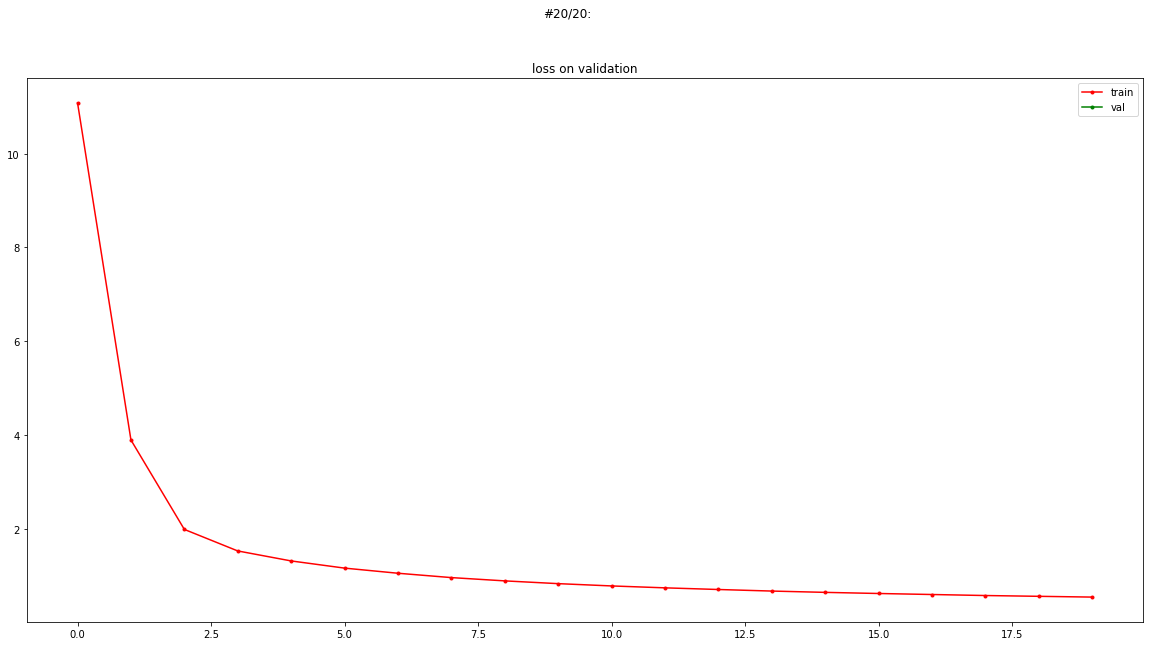

In [121]:
masked_biobert, optimizer, losses = learning_loop(
    model=masked_biobert,
    epochs=epochs,
    optimizer=optimizer,
    train_loader=ncbi_train_big_dataloader,
    test_loader=None,
    scheduler=scheduler
)

In [122]:
masked_biobert.save_pretrained("masked_biobert_pretrained")

## Training

In [7]:
!ls ../datasets/NCBI

NCBI-disease		   NCBItrainset_corpus.zip  test_dictionary.txt
NCBI_corpus.zip		   dev			    test_texts_exp.txt
NCBIdevelopset_corpus.txt  dev_dictionary.txt	    train
NCBIdevelopset_corpus.zip  processed_dev	    train_dictionary.txt
NCBItestset_corpus.txt	   processed_test	    train_texts_exp.txt
NCBItestset_corpus.zip	   processed_train	    val_texts_exp.txt
NCBItrainset_corpus.txt    test


In [8]:
train_dict_path = "../datasets/NCBI/train_dictionary.txt"
val_dict_path = "../datasets/NCBI/dev_dictionary.txt"
processed_train_path = "../datasets/NCBI/processed_train"
processed_val_path = "../datasets/NCBI/processed_dev"

model_name = "masked_biobert_pretrained"
tok_name = "dmis-lab/biobert-base-cased-v1.1"

max_length = 25
k = 20
batch_size = 14
# batch_size = 5

In [9]:
device

device(type='cuda', index=2)

In [10]:
train_dictionary = DictDataset(train_dict_path).data
val_dictionary = DictDataset(val_dict_path).data

In [11]:
train_concept_dataset = ConceptDataset(
    data_path=processed_train_path,
    filter_duplicates=True,
    filter_without_cui=True,
    filter_composite_names=True
).data

val_concept_dataset = ConceptDataset(
    data_path=processed_val_path,
    filter_duplicates=True,
    filter_without_cui=True,
    filter_composite_names=True
).data

100%|██████████| 100/100 [00:00<00:00, 47559.86it/s]


In [12]:
train_dictionary_names = train_dictionary[:,0]
train_concept_names = train_concept_dataset[:,0]

val_dictionary_names = val_dictionary[:,0]
val_concept_names = val_concept_dataset[:,0]

In [37]:
del model, adynorm.encoder, optimizer

In [38]:
adynorm = Adynorm(
    max_length=max_length,
    device=device
)

In [39]:
adynorm.load(model_name, tok_name)

Some weights of the model checkpoint at masked_biobert_pretrained were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at masked_biobert_pretrained and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.

In [40]:
model = AdynormNet(encoder=adynorm.get_encoder()).to(device)

In [41]:
train_dataset = CandidateDataset(
    concepts=train_concept_dataset, 
    dictionary=train_dictionary, 
    tokenizer=adynorm.get_tokenizer(), 
    k=k, 
    max_length=max_length
)

val_dataset = CandidateDataset(
    concepts=val_concept_dataset, 
    dictionary=val_dictionary, 
    tokenizer=adynorm.get_tokenizer(), 
    k=k, 
    max_length=max_length
)

In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [43]:
def criterion(logits, beta, y):
    probs = nn.Sigmoid()(logits)
    probs = torch.cat([1 - probs, probs], axis=1)
#     entropy = (probs * torch.log(probs)).mean()
#     nll = torch.log(probs.gather(1, y.unsqueeze(1))).mean()
    entropy = (probs * torch.log(probs)).sum()
    nll = torch.log(probs.gather(1, y.unsqueeze(1))).sum()
    loss = -beta * entropy - nll
    return loss

In [44]:
def train(model, optimizer, loader, beta, criterion):
    model.train()
    losses_tr = []
    for X, y in tqdm(loader):
        optimizer.zero_grad()
        
        X['input_ids'] = X['input_ids'].reshape(-1, max_length).to(device)
        X['attention_mask'] = X['attention_mask'].reshape(-1, max_length).to(device)
        X['token_type_ids'] = X['token_type_ids'].reshape(-1, max_length).to(device)
        
        y = y.flatten().to(device)
        
        output = model(X)
        loss = criterion(output, beta, y)
        
        loss.backward()
        optimizer.step()
#         scheduler.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, beta, criterion):
    model.eval()
    losses_val = []
    with torch.no_grad():
        for X, y in tqdm(loader):
            X['input_ids'] = X['input_ids'].reshape(-1, max_length).to(device)
            X['attention_mask'] = X['attention_mask'].reshape(-1, max_length).to(device)
            X['token_type_ids'] = X['token_type_ids'].reshape(-1, max_length).to(device)

            y = y.flatten().to(device)
            
            output = model(X)
            loss = criterion(output, beta, y)

#             loss = outputs.loss
            losses_val.append(loss.item())
    
    return np.mean(losses_val)

In [45]:
import gc

def clear_cuda_cache():
    gc.collect()

    torch.cuda.empty_cache()

In [46]:
from IPython.display import clear_output
from tqdm.notebook import trange


def learning_loop(
    model,
    adynorm,
    optimizer,
    train_dataset,
    val_dataset,
    train_concept_names,
    val_concept_names,
    train_dictionary_names,
    val_dictionary_names,
    train_loader,
    val_loader,
    criterion,
    beta=1.0,
    scheduler=None,
    epochs=20,
    k=20,
    use_tqdm=True
):
    losses = {'train': [], 'val': []}
    
    loss = 0
    for epoch in range(1, epochs+1):
        clear_cuda_cache()
        print(f'#{epoch}/{epochs}:')
        print(f"Loss: {loss}")
        
        train_concepts_embeds = adynorm.get_embeddings(mentions=train_concept_names, use_tqdm=use_tqdm)
        train_dictionary_embeds = adynorm.get_embeddings(mentions=train_dictionary_names, use_tqdm=use_tqdm)

        train_score_matrix = adynorm.get_score_matrix(
                mention_embeddings=train_concepts_embeds, 
                dictionary_embeddings=train_dictionary_embeds
            )
        train_candidate_idxs = adynorm.get_candidate_indexes(
            score_matrix=train_score_matrix, 
            k=k
        )
        train_dataset.load_dense_idxs(train_candidate_idxs)
        
        model, optimizer, loss = train(
            model=model,
            optimizer=optimizer,
            loader=train_dataloader,
            criterion=criterion,
            beta=beta
        )
        losses['train'].append(loss)

        clear_cuda_cache()
        
        val_concepts_embeds = adynorm.get_embeddings(mentions=val_concept_names, use_tqdm=use_tqdm)
        val_dictionary_embeds = adynorm.get_embeddings(mentions=val_dictionary_names, use_tqdm=use_tqdm)

        val_score_matrix = adynorm.get_score_matrix(
                mention_embeddings=val_concepts_embeds, 
                dictionary_embeddings=val_dictionary_embeds
        )
        val_candidate_idxs = adynorm.get_candidate_indexes(
            score_matrix=val_score_matrix, 
            k=k
        )
        val_dataset.load_dense_idxs(val_candidate_idxs)
        
        loss = val(
            model=model,
            loader=val_dataloader,
            criterion=criterion,
            beta=beta
        )

        losses['val'].append(loss)
        if scheduler:
            scheduler.step(loss)
        
        clear_output(True)
        fig, ax = plt.subplots(1, 1, figsize=(20, 10))
        fig.suptitle(f'#{epoch}/{epochs}:')

        plt.plot(losses['train'], 'r.-', label='train')
        plt.legend()

        plt.title('losses')
        plt.plot(losses['val'], 'g.-', label='val')
        plt.legend()

        plt.show()
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'adynorm_ch_{epoch}_lr_sum.ckpt')
            adynorm.save(f'adynorm_ch_{epoch}_lr_sum')

    return model, optimizer, losses

In [47]:
optimizer = torch.optim.Adam(model.parameters(), 5e-8, (0.9, 0.999), weight_decay=1e-2)

In [143]:
# optimizer1 = torch.optim.Adam(model.parameters(), 1e-7, (0.9, 0.999), weight_decay=1e-2)

In [24]:
# optimizer = torch.optim.Adam(model.parameters(), 5e-5, (0.9, 0.999), weight_decay=1e-2)

In [26]:
adynorm.load('adynorm_ch_obj_add_40')
model.load_state_dict(torch.load('adynorm_ch_add_40.ckpt'))

<All keys matched successfully>

In [48]:
beta = 0.35

In [49]:
clear_cuda_cache()

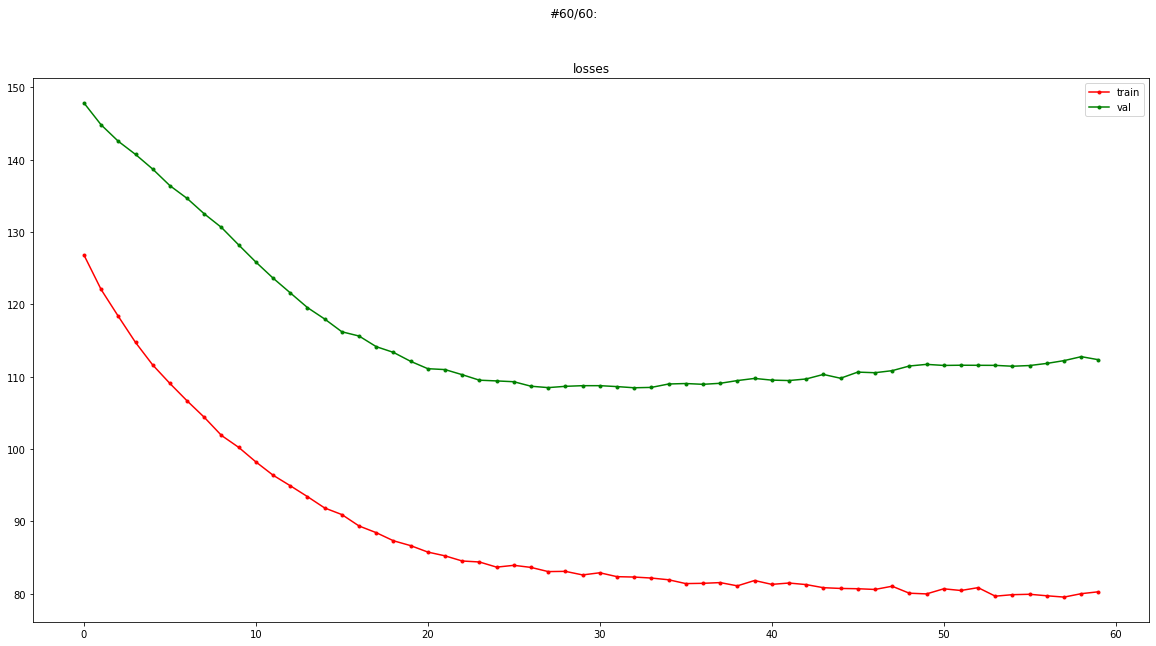

In [51]:
model, optimizer, losses = learning_loop(
    model=model,
    adynorm=adynorm,
    optimizer=optimizer,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    train_concept_names=train_concept_names,
    val_concept_names=val_concept_names,
    train_dictionary_names=train_dictionary_names,
    val_dictionary_names=val_dictionary_names,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    beta=beta,
    epochs=60
)

In [ ]:
# for epoch in range(1):
#     train_concepts_embeds = adynorm.get_embeddings(mentions=concept_names, use_tqdm=True)
#     train_dictionary_embeds = adynorm.get_embeddings(mentions=dictionary_names, use_tqdm=True)
    
#     train_score_matrix = adynorm.get_score_matrix(
#             mention_embeddings=train_concepts_embeds, 
#             dictionary_embeddings=train_dictionary_embeds
#         )
#     train_candidate_idxs = adynorm.get_candidate_indexes(
#         score_matrix=train_score_matrix, 
#         k=k
#     )
#     train_dataset.load_dense_idxs(train_candidate_idxs)
#     model, optimizer, loss = train(
#         model=model,
#         optimizer=optimizer,
#         loader=train_dataloader,
#         criterion=criterion,
#         beta=beta
#     )
#     print(loss)
    
    

In [28]:
def get_k(preds):
    return len(preds[0]['mentions'][0]['candidates'])

In [29]:
def get_label(cui, real_cui):
    return int(len(set(cui.split('|')).intersection(set(real_cui.split('|')))) > 0)

In [67]:
def predict(adynorm, model, dictionary, concepts, k):
    encoder = adynorm.get_encoder()
    tokenizer = adynorm.get_tokenizer()
    
    dictionary_embeddings = adynorm.get_embeddings(dictionary[:, 0], use_tqdm=True)
    preds = []
    
    for concept in tqdm(concepts):
        mentions = concept[0].split('|')
        real_cuis = concept[1]
        
        dictionary_mentions = []
        for mention in mentions:
            mention_embedding = adynorm.get_embeddings(np.array([mention]))
            
            score_matrix = adynorm.get_score_matrix(mention_embedding, dictionary_embeddings)
            candidate_indexes = adynorm.get_candidate_indexes(score_matrix, k)
            score_matrix = score_matrix.squeeze()
#             print(candidate_indexes)
#             print(score_matrix.shape)
#             print(score_matrix[candidate_indexes.squeeze()])
            scores_sb = score_matrix[candidate_indexes.squeeze()]
            
            candidates = dictionary[candidate_indexes].squeeze()

            candidate_dataset = CandidateDataset([(mention, '')], dictionary, tokenizer, k, max_length)
            candidate_dataset.load_dense_idxs(candidate_indexes)
            
            model.eval()
            with torch.no_grad():
                scores_rb = nn.Sigmoid()(model(candidate_dataset[0][0]))
#                 print(scores_rb)
            final_scores = scores_rb.squeeze() + scores_sb
            sorted_args_desc = torch.argsort(final_scores, descending=True)
#             print(mention)
#             print(candidates)
            candidates = candidates[sorted_args_desc.detach().numpy()]
#             print(candidates)
            dictionary_candidates = []
            for i, candidate in enumerate(candidates):
                dictionary_candidates.append(
                    {
                        'name': candidate[0],
                        'cui': candidate[1],
                        'label': get_label(candidate[1], real_cuis),
                        'score_sb': scores_sb[sorted_args_desc[i]],
                        'score_rb': scores_rb[sorted_args_desc[i]].item(),
                        'score': final_scores[sorted_args_desc[i]].item()
                    }
                )
            dictionary_mentions.append(
                {
                    'mention': mention,
                    'real cui': real_cuis,
                    'candidates': dictionary_candidates
                }
            )
        preds.append(
            {
                'mentions': dictionary_mentions
            }
        )
    return {'preds': preds}

In [66]:
def evaluate_k_acc(output):
    preds = output['preds']
#     k = get_k(preds)
    k = 5
    for i in range(k):
        hit = 0
        for pred in preds:
            mentions = pred['mentions']
            mention_hit = 0
            for mention in mentions:
                candidates = mention['candidates'][: i + 1]
                mention_hit += np.any([candidate['label'] for candidate in candidates])
            
            if mention_hit == len(mentions):
                hit +=1
        
        output['acc{}'.format(i + 1)] = hit / len(preds)

    return output

In [68]:
def evaluate(adynorm, model, dictionary, mentions, k):
    output = predict(adynorm, model, dictionary, mentions, k)
    result = evaluate_k_acc(output)
    
    return result

In [271]:
!ls

Adynorm.ipynb	 adynorm_20.ckpt  adynorm_obj_15  output	trunk
adynorm_10.ckpt  adynorm_5.ckpt   adynorm_obj_20  preprocess
adynorm_15.ckpt  adynorm_obj_10   adynorm_obj_5   saved_models


In [58]:
# best -- adynorm_ch_55_lr_sum

In [63]:
adynorm.load('adynorm_ch_55_lr_sum', 'adynorm_ch_55_lr_sum')
model.load_state_dict(torch.load('adynorm_ch_55_lr_sum.ckpt'))

<All keys matched successfully>

In [74]:
model.encoder = adynorm.encoder
model.load_state_dict(torch.load('adynorm_ch_add_40.ckpt'))

<All keys matched successfully>

In [107]:
result = evaluate(adynorm, model.to('cpu'), val_dictionary, val_concept_dataset, 35)

  0%|          | 0/72 [00:00<?, ?it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
  0%|          | 1/311 [00:00<03:47,  1.36it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
  1%|          | 2/311 [00:01<03:50,  1.34it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {

  7%|▋         | 23/311 [00:16<03:27,  1.39it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
  8%|▊         | 24/311 [00:17<03:26,  1.39it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
  8%|▊         | 25/311 [00:18<03:28,  1.37it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

 15%|█▍        | 46/311 [00:33<03:06,  1.42it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 15%|█▌        | 47/311 [00:33<03:06,  1.42it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 15%|█▌        | 48/311 [00:34<03:06,  1.41it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

 22%|██▏       | 69/311 [00:49<02:54,  1.39it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 23%|██▎       | 70/311 [00:50<02:51,  1.40it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 23%|██▎       | 71/311 [00:51<02:56,  1.36it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

 30%|██▉       | 92/311 [01:06<02:36,  1.40it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 30%|██▉       | 93/311 [01:07<02:33,  1.42it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 30%|███       | 94/311 [01:07<02:31,  1.44it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor)

 37%|███▋      | 115/311 [01:22<02:21,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 37%|███▋      | 116/311 [01:23<02:20,  1.39it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 38%|███▊      | 117/311 [01:24<02:19,  1.39it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 44%|████▍     | 138/311 [01:39<02:17,  1.26it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 45%|████▍     | 139/311 [01:40<02:13,  1.29it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 45%|████▌     | 140/311 [01:41<02:09,  1.32it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 52%|█████▏    | 161/311 [01:56<01:47,  1.40it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 52%|█████▏    | 162/311 [01:57<01:46,  1.41it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 52%|█████▏    | 163/311 [01:57<01:44,  1.41it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 59%|█████▉    | 184/311 [02:13<01:32,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 59%|█████▉    | 185/311 [02:13<01:32,  1.37it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 60%|█████▉    | 186/311 [02:14<01:31,  1.37it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 67%|██████▋   | 207/311 [02:29<01:16,  1.37it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 67%|██████▋   | 208/311 [02:30<01:13,  1.41it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 67%|██████▋   | 209/311 [02:31<01:13,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 74%|███████▍  | 230/311 [02:46<00:58,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 74%|███████▍  | 231/311 [02:47<00:57,  1.39it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 75%|███████▍  | 232/311 [02:47<00:56,  1.41it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 81%|████████▏ | 253/311 [03:03<00:42,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 82%|████████▏ | 254/311 [03:03<00:41,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 82%|████████▏ | 255/311 [03:04<00:40,  1.38it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 89%|████████▊ | 276/311 [03:20<00:26,  1.33it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 89%|████████▉ | 277/311 [03:20<00:25,  1.34it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 89%|████████▉ | 278/311 [03:21<00:24,  1.36it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

 96%|█████████▌| 299/311 [03:36<00:08,  1.42it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 96%|█████████▋| 300/311 [03:37<00:07,  1.41it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[index]) for key, val in self.embeddings.items()}
 97%|█████████▋| 301/311 [03:38<00:07,  1.40it/s]<ipython-input-3-3009714e5f59>:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

In [108]:
result

{'preds': [{'mentions': [{'mention': 'breast and or ovarian cancer',
     'real cui': 'D061325',
     'candidates': [{'name': 'breast and or ovarian cancer',
       'cui': 'D061325',
       'label': 1,
       'score_sb': 0.99999976,
       'score_rb': 0.8217113614082336,
       'score': 1.8217110633850098},
      {'name': 'hereditary breast or ovarian cancer',
       'cui': 'D061325',
       'label': 1,
       'score_sb': 0.9770355,
       'score_rb': 0.7941379547119141,
       'score': 1.7711734771728516},
      {'name': 'breast and ovarian cancer',
       'cui': 'D061325|-1',
       'label': 1,
       'score_sb': 0.9825777,
       'score_rb': 0.7554287314414978,
       'score': 1.738006353378296},
      {'name': 'breast ovarian cancer',
       'cui': 'D001943|D061325',
       'label': 1,
       'score_sb': 0.95103234,
       'score_rb': 0.7250195145606995,
       'score': 1.6760518550872803},
      {'name': 'breast and ovarian cancers',
       'cui': 'D061325',
       'label': 1,
   

In [84]:
result['preds'][0]['mentions']

[{'mention': 'breast and or ovarian cancer',
  'real cui': 'D061325',
  'candidates': [{'name': 'breast and or ovarian cancer',
    'cui': 'D061325',
    'label': 1,
    'score_sb': 0.99999976,
    'score_rb': 0.8217113614082336,
    'score': 1.8217110633850098},
   {'name': 'hereditary breast or ovarian cancer',
    'cui': 'D061325',
    'label': 1,
    'score_sb': 0.9770355,
    'score_rb': 0.7941379547119141,
    'score': 1.7711734771728516},
   {'name': 'breast and ovarian cancer',
    'cui': 'D061325|-1',
    'label': 1,
    'score_sb': 0.9825777,
    'score_rb': 0.7554287314414978,
    'score': 1.738006353378296},
   {'name': 'breast ovarian cancer',
    'cui': 'D001943|D061325',
    'label': 1,
    'score_sb': 0.95103234,
    'score_rb': 0.7250195145606995,
    'score': 1.6760518550872803},
   {'name': 'breast and ovarian cancers',
    'cui': 'D061325',
    'label': 1,
    'score_sb': 0.9649533,
    'score_rb': 0.7054951786994934,
    'score': 1.6704485416412354},
   {'name': 'h

In [89]:
name = 'inherited cancer syndrome'
candidates = []
score_sb = []
score_rb = []
final_score = []
for mentions in result['preds']:
    for mention in mentions['mentions']:
        if mention['mention'] == name:
            for cand in mention['candidates']:
                candidates.append(cand['name'])
                score_sb.append(cand['score_sb'])
                score_rb.append(cand['score_rb'])
                final_score.append(cand['score'])

In [101]:
candidates = np.array(candidates)
score_sb = np.array(score_sb)
score_rb = np.array(score_rb)
final_score = np.array(final_score)

In [95]:
indexes = np.argsort(score_sb)[::-1][:5]

In [96]:
candidates[indexes]

array(['hereditary cancer syndrome', 'cancer syndrome hereditary',
       'hereditary tumor syndrome', 'cancer syndromes hereditary',
       'hereditary neoplastic syndrome'], dtype='<U46')

In [99]:
score_sb[indexes]

array([0.9943619 , 0.99005383, 0.9869263 , 0.9846033 , 0.98390585],
      dtype=float32)

In [100]:
score_rb[indexes]

array([0.10345782, 0.35001355, 0.01163598, 0.32268676, 0.00920982])

In [102]:
indexes = np.argsort(final_score)[::-1][:5]

In [103]:
candidates[indexes]

array(['cancer syndrome hereditary', 'cancer syndromes hereditary',
       'hereditary cancer syndromes', 'syndromes hereditary cancer',
       'hereditary cancer syndrome'], dtype='<U46')

In [104]:
final_score[indexes]

array([1.34006739, 1.30729008, 1.16663134, 1.16518795, 1.09781969])

In [44]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/reddit_sample.json

--2021-11-22 10:26:29--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/reddit_sample.json
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.168.45
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.168.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84547551 (81M) [application/json]
Saving to: ‘reddit_sample.json’

reddit_sample.json  100%[===================>]  80.63M  8.26MB/s    in 13s     

2021-11-22 10:26:43 (6.00 MB/s) - ‘reddit_sample.json’ saved [84547551/84547551]



In [45]:
import datasets
reddit = datasets.load_dataset('json', data_files='./reddit_sample.json')

Using custom data configuration default-4a79b9c6db5e510c


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/svbeljasov/.cache/huggingface/datasets/json/default-4a79b9c6db5e510c/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
reddit['train'][500]['words']

['the',
 'most',
 'fun',
 'I',
 'had',
 'there',
 'was',
 'whipping',
 'out',
 'Google',
 'Translate',
 'and',
 'attempting',
 'to',
 'hold',
 'a',
 'conversation',
 'with',
 'a',
 'non-English',
 'speaking',
 'hispanic',
 'girl',
 'that',
 'ran',
 'away',
 'from',
 'an',
 'abusive',
 'relationship',
 'and',
 'did',
 "n't",
 'have',
 'anyone',
 'to',
 'talk',
 'to',
 'the',
 'whole',
 'time',
 'she',
 'was',
 'at',
 'the',
 'shelter',
 '.']